# Defining custom Greta distributions

Greta is an R package for deep probabilistic programming and Bayesian modelling, similiar to Edward, PyMC3 or Pyro. One of Greta's key features is its easy extensibility that allows definition of custom functions that get translated and run with Tensorflow automatically. Here, I'll show how one can use Greta to define custom probability distributions for cases when Greta doesn't it already.

To setup your own distribution and do a statistical analysis with it, we first load some required libraries. To
define a custom distribution, we need `R6` since that is the way Greta distributions are written with. For the analysis of our model, we load `bayesplot` and `coda` for diagnostics.

In [1]:
library(greta)
library(R6)
library(bayesplot)
library(coda)

options(repr.plot.width=10, repr.plot.height=4)


Attaching package: ‘greta’

The following objects are masked from ‘package:stats’:

    binomial, cov2cor, poisson

The following objects are masked from ‘package:base’:

    %*%, apply, backsolve, beta, chol2inv, colMeans, colSums, diag,
    eigen, forwardsolve, gamma, identity, rowMeans, rowSums, sweep,
    tapply

This is bayesplot version 1.6.0
- Online documentation and vignettes at mc-stan.org/bayesplot
- bayesplot theme set to bayesplot::theme_default()
   * Does _not_ affect other ggplot2 plots
   * See ?bayesplot_theme_set for details on theme setting

Attaching package: ‘coda’

The following object is masked from ‘package:greta’:

    mcmc



Note that `coda::mcmc` masks `greta::mcmc` which means we should namespace the functions we use (we should do that at all times anyways).

If we have a look at a distribution that Greta is providing we see that it's basically only a couple of lines that are required. For instance, the  hypergeometric distribution in `R/probability_distributions.R` in the Greta package looks something like this:

In [2]:
hypergeometric_distribution <- R6Class(
  "hypergeometric_distribution",
  inherit = distribution_node,
  public = list(

    initialize = function(m, n, k, dim) {
      m <- as.greta_array(m)
      n <- as.greta_array(n)
      k <- as.greta_array(k)
      dim <- check_dims(m, n, k, target_dim = dim)
      super$initialize("hypergeometric", dim, discrete = TRUE)
      self$add_parameter(m, "m")
      self$add_parameter(n, "n")
      self$add_parameter(k, "k")
    },

    tf_distrib = function(parameters, dag) {
      m <- parameters$m
      n <- parameters$n
      k <- parameters$k
      log_prob <- function(x) {
        tf_lchoose(m, x) + tf_lchoose(n, k - x) - tf_lchoose(m + n, k)
      }
      list(log_prob = log_prob, cdf = NULL, log_cdf = NULL)
    },
    
    tf_cdf_function = NULL,
    tf_log_cdf_function = NULL
  )
)

As noted above, a `distribution` in Greta is an `R6` class that inherits from a class `distribution_node`, has a constructor that takes as arguments the parameters of the distribution we want to create and a dimension argument (`dim`). For some distributions we also have arguments like `truncate` when we want to truncate the distribution, for instance, to get a half-normal distribution. Within the constructor we cast the parameters using `as.greta_array`, check for correct dimensionality with `check_dims`, initialize the object, and add the parameters of the distribution as members to the object. The second method (`tf_distrib`) needs to define a nested function `log_prob` the computes the logarithm of the mass (or density) function.

Note that, since Greta uses Tensorflow in the backend, we need to use functions from the `tensorflow` package here. The last part of the distribution class sets `tf_cdf_function` and `tf_log_cdf_function` to `NULL`.

Having learnt how Greta defines distributions, we can try to implement one ourselves: a multivariate Bernoulli distribution, i.e. a $p$-dimensional distribution of independent Bernoullis. 

Since much of the functionality in the class above is private, we first define some utility functions from Greta:

In [3]:
distribution_node <- .internals$nodes$node_classes$distribution_node
as.greta_array    <- .internals$greta_arrays$as.greta_array
check_dims <- .internals$utils$checks$check_dims
distrib    <- .internals$nodes$constructors$distrib
fl     <- .internals$utils$misc$fl
tf_sum <- greta:::tf_sum

Then we define the multivariate Bernoulli (or whatever you want to call it):

In [4]:
multivariate_bernoulli_distribution <- R6Class(
  "multivariate_bernoulli_distribution",
  inherit = distribution_node,
  public = list(
    initialize = function(prob, dim) {
      prob <- as.greta_array(prob)
      dim <- check_dims(prob, target_dim = dim)
      super$initialize("multivariate_bernoulli", dim, discrete = TRUE)
      self$add_parameter(prob, "prob")
    },
    
    tf_distrib = function(parameters, dag) {
      prob <- parameters$prob
      log_prob <- function(x) {
        tf_sum(x * log(prob) + (fl(1) - x) * log(fl(1) - prob))
      }
      
      list(log_prob = log_prob, cdf = NULL, log_cdf = NULL)
    },
    
    tf_cdf_function = NULL,
    tf_log_cdf_function = NULL
  )
)

The definition is precisely as for the hypergeometric distribution, only that we needed to change the parameters. In this case we the arguments are a $p$-dimensional vector of sucess probabilities. As for the hypergeometric distribution, we only need to set up the constructor, implement a `tf_distrib` function and define the log-probability. Additionally, we write a nice wrapper function that creates an object:

In [5]:
multivariate_bernoulli <- function(prob, dim = NULL) {
  distrib("multivariate_bernoulli", prob, dim)
}

That's pretty much it. Let's test our distribution with a small example. We set up a data set of 90 samples of a three-dimensional Bernoulli mixture.

In [6]:
n <- 30
p <- 3
k <- 3
(probs <- seq(0.1, 0.9, length.out = k))

d <- rbind(
  matrix(rbinom(n * p, 1, probs[1]), n),
  matrix(rbinom(n * p, 1, probs[2]), n),
  matrix(rbinom(n * p, 1, probs[3]), n)
)

[1] 0.1 0.5 0.9

The code above creates data from a three-component mixture model of multi-variate Bernoullis with different success probablities.
Now, let's mdoel this in Greta. First we set up the priors we need. Since Greta so far does not provide an `ordered` keyword like Stan does, we need to make use of non-exchangable priors for the success probabilities of the single Bernoullis. Otherwise the posteriors would not be identifiable.

The Beta distribution is a natural choice for the priors. Choosing different hyperparameters let's us put most of the density differntly for each component. Since we use three components, I parameterize the priors such that the main part of the density is around $0.1$, $0.5$ and $0.9$.

The plots below show this:

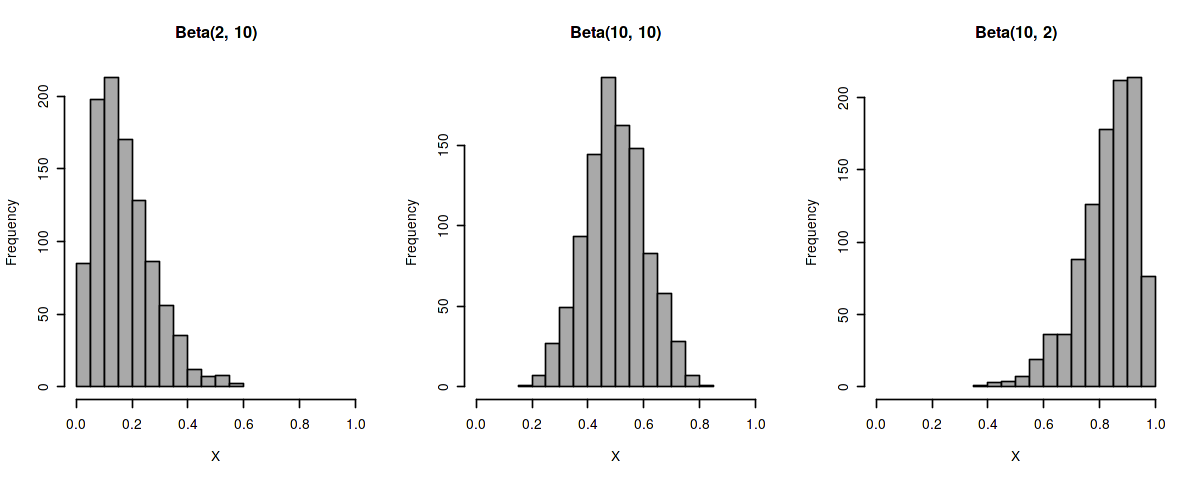

In [7]:
par(mfrow=c(1, 3))
hist(rbeta(1000, 2, 10), col = "darkgrey", xlab="X", main="Beta(2, 10)", xlim=c(0, 1))
hist(rbeta(1000, 10, 10), col = "darkgrey", xlab="X", main="Beta(10, 10)", xlim=c(0, 1))
hist(rbeta(1000, 10, 2), col = "darkgrey", xlab="X", main="Beta(10, 2)", xlim=c(0, 1))
par(mfrow=c(1, 1))

Defining this in Greta is quite easy:

In [8]:
theta1 <- greta::beta(2, 10, dim = p)
theta2 <- greta::beta(10, 10, dim = p)
theta3 <- greta::beta(10, 2, dim = p)

pi <- greta::uniform(0, 1, 3)

Then we model the distribution of every observation in our data set.

In [9]:
for (i in seq(nrow(d)))
{
  distribution(d[i,]) <- greta::mixture(
    multivariate_bernoulli(theta1),
    multivariate_bernoulli(theta2),
    multivariate_bernoulli(theta3),
    weights = pi)
}

The steps above were the ones that took us most of the time to implement while it is simple for the computer. Inferring the posteriors is easy for us, but very hard for the computer on the other hand:

In [10]:
mod <- greta::model(theta1, theta2, theta3)
samples <- greta::mcmc(mod)


running 4 chains simultaneously on up to 4 cores

    warmup ====================================== 1000/1000 | eta:  0s | 1% bad 
  sampling ====================================== 1000/1000 | eta:  0s          


Let's check if the inference worked out nicely.
First, we have a look at potential scale reduction factors to check for possible divergences.

In [11]:
coda::gelman.diag(samples)

Potential scale reduction factors:

            Point est. Upper C.I.
theta1[1,1]       1.00       1.00
theta1[2,1]       1.00       1.01
theta1[3,1]       1.00       1.00
theta2[1,1]       1.00       1.01
theta2[2,1]       1.00       1.01
theta2[3,1]       1.00       1.01
theta3[1,1]       1.00       1.01
theta3[2,1]       1.01       1.02
theta3[3,1]       1.00       1.00

Multivariate psrf

1.01

Looks ok, none of the estimates are greater than 1.05 which is usually a good indicator. In addition it always makes sense to look at the effective sample size.

In [12]:
coda::effectiveSize(samples)

theta1[1,1] theta1[2,1] theta1[3,1] theta2[1,1] theta2[2,1] theta2[3,1] 
   2602.340    2414.659    2504.246    2529.472    2766.639    2757.446 
theta3[1,1] theta3[2,1] theta3[3,1] 
   2208.282    2351.802    2535.301

Finally, we should have a look at the posterior traces to see if some chain went wrong.

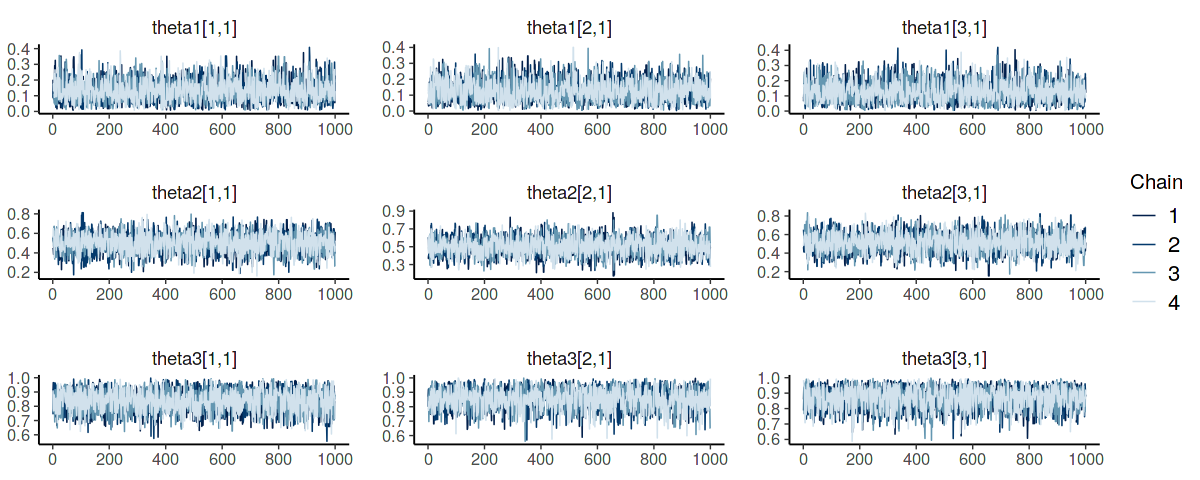

In [13]:
bayesplot::mcmc_trace(samples)

The three diagnostics above pose a great way to check your model and if something went wrong. Often, if, for instance, the psrfs are high or effective sample size is very low, we might have poorly designed our model and need to put more thought into constructing priors or simplifying parts of the model.

Finally let's look at the posteriors and if we could infer the parameters, i.e. the success probabilities.

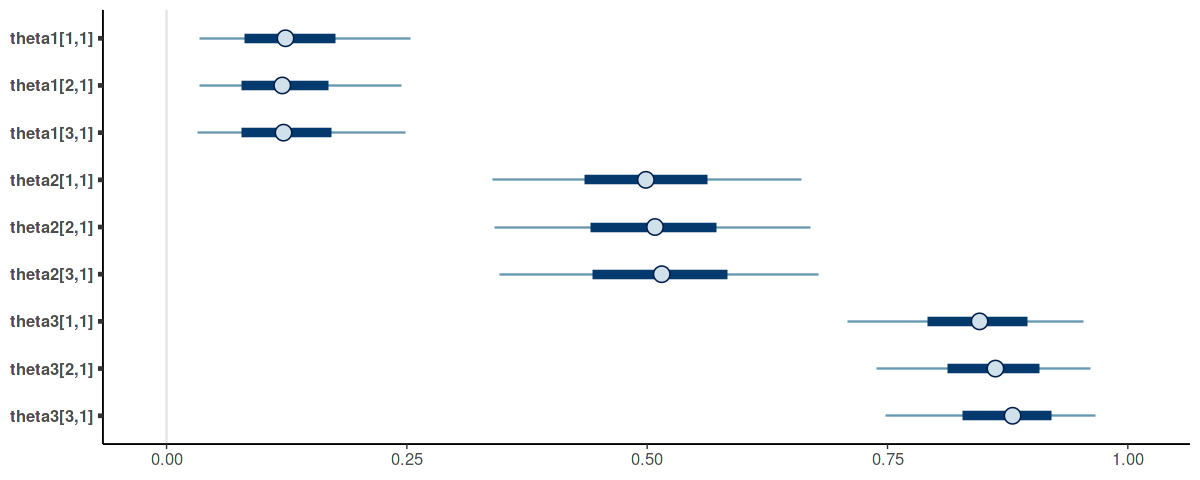

In [14]:
bayesplot::mcmc_intervals(samples)

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


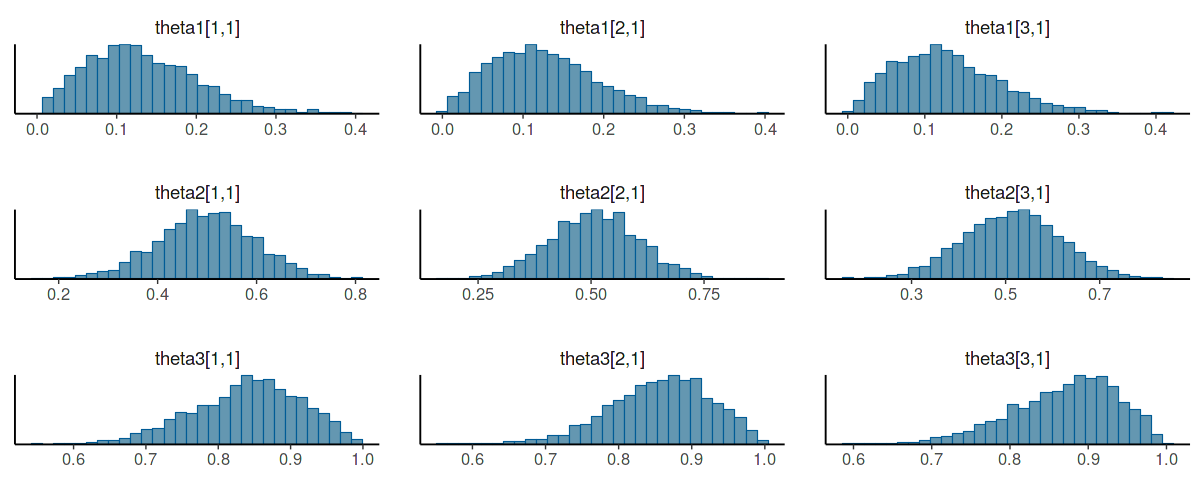

In [15]:
bayesplot::mcmc_hist(samples)